<a href="https://colab.research.google.com/github/SardarAmmer/DataScience-Projects-/blob/main/DEN_Final_Task_(_SpaceX_Analysis)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project folders created at: /content/spacex_project


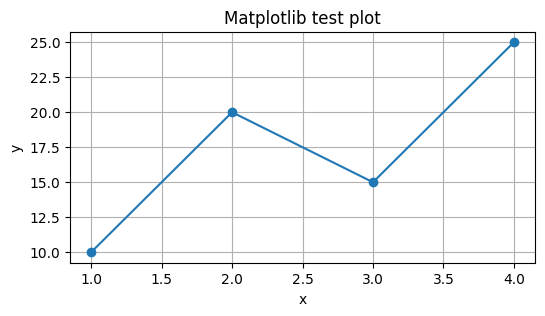


✅ Environment setup complete.


In [2]:
# @title Final Project SpaceX Analysis
# Step 0: Environment setup for SpaceX capstone (Colab)


# 1) Installing packages
!pip install -q folium plotly jupyter-dash pandasql lxml html5lib dash

# 2) Notebook display configuration
%matplotlib inline

import os, random, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 3) Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# 4) Creating project folders
BASE = '/content/spacex_project'
DATA_RAW = os.path.join(BASE, 'data_raw')
DATA_CLEAN = os.path.join(BASE, 'data_clean')
FIGS = os.path.join(BASE, 'figs')
MODELS = os.path.join(BASE, 'models')

for d in (BASE, DATA_RAW, DATA_CLEAN, FIGS, MODELS):
    os.makedirs(d, exist_ok=True)

print("Project folders created at:", BASE)

# 5) Plotly and Folium setup for inline display
import plotly
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

try:
    plotly.io.renderers.default = 'colab'
except Exception:
    pass

import folium
from jupyter_dash import JupyterDash

#Testing Libraries visuals

# Matplotlib test
plt.figure(figsize=(6,3))
plt.plot([1,2,3,4], [10,20,15,25], marker='o')
plt.title('Matplotlib test plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Plotly test
df_test = pd.DataFrame({'category': ['A','B','C','D'], 'value':[10,15,7,12]})
fig = px.bar(df_test, x='category', y='value', title='Plotly test bar chart')
fig.show()

# Folium test map (Kennedy Space Center coords) - should render inline
m = folium.Map(location=[28.572872, -80.648980], zoom_start=5)
folium.Marker([28.572872, -80.648980], popup='Kennedy Space Center (test)').add_to(m)

# Display map inline
display(m)

# 7) Summary
print("\n✅ Environment setup complete.")




In [3]:
# @title Data Collection Using SpaceX API

# Collect data from SpaceX REST API

import requests
import pandas as pd
import plotly.express as px

# --- Helper function ---
def fetch_data(url):
    r = requests.get(url)
    r.raise_for_status()
    return r.json()

# --- API Endpoints ---
urls = {
    "launches": "https://api.spacexdata.com/v4/launches",
    "rockets": "https://api.spacexdata.com/v4/rockets",
    "payloads": "https://api.spacexdata.com/v4/payloads",
    "cores": "https://api.spacexdata.com/v4/cores",
    "launchpads": "https://api.spacexdata.com/v4/launchpads",
    "landpads": "https://api.spacexdata.com/v4/landpads"
}

# --- Fetch & Normalize ---
df_launches = pd.json_normalize(fetch_data(urls["launches"]))
df_rockets = pd.json_normalize(fetch_data(urls["rockets"]))
df_payloads = pd.json_normalize(fetch_data(urls["payloads"]))
df_cores = pd.json_normalize(fetch_data(urls["cores"]))
df_launchpads = pd.json_normalize(fetch_data(urls["launchpads"]))
df_landpads = pd.json_normalize(fetch_data(urls["landpads"]))

print("✅ Data successfully collected from SpaceX API")
print("Launches:", df_launches.shape, "Rockets:", df_rockets.shape, "Payloads:", df_payloads.shape)

# --- Quick Preview ---
display(df_launches[["name","date_utc","rocket","payloads","cores"]].head(5))

# --- Graphical Overview: launches per year ---
df_launches['year'] = pd.to_datetime(df_launches['date_utc']).dt.year
launches_per_year = df_launches['year'].value_counts().sort_index()

fig = px.line(
    x=launches_per_year.index,
    y=launches_per_year.values,
    markers=True,
    labels={'x':'Year','y':'Number of Launches'},
    title="Number of SpaceX Launches Per Year (API Data)"
)
fig.show()


✅ Data successfully collected from SpaceX API
Launches: (205, 43) Rockets: (4, 56) Payloads: (225, 34)


,name,date_utc,rocket,payloads,cores
0,FalconSat,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],"[{'core': '5e9e289df35918033d3b2623', 'flight'..."
1,DemoSat,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],"[{'core': '5e9e289ef35918416a3b2624', 'flight'..."
2,Trailblazer,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...","[{'core': '5e9e289ef3591814873b2625', 'flight'..."
3,RatSat,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e5],"[{'core': '5e9e289ef3591855dc3b2626', 'flight'..."
4,RazakSat,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e6],"[{'core': '5e9e289ef359184f103b2627', 'flight'..."


/tmp/ipython-input-2364406268.py:13: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



✅ 16 tables found on the page
Wiki Table Shape: (213, 10)


,Flight No.,Date and time (UTC),"Version, booster[i]",Launch site,Payload[j],Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,418,"January 4, 2025 01:27[254]",F9 B5 B1073‑20,"Cape Canaveral, SLC‑40",Thuraya 4-NGS,"5,000 kg (11,000 lb)",GTO,Thuraya,Success,Success (ASOG)
1,418,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...,Planned replacement for Thuraya 2 and 3.[255][...
2,419,"January 6, 2025 20:43[257]",F9 B5 B1077‑17,"Cape Canaveral, SLC‑40",Starlink: Group 6‑71 (24 satellites),"~17,500 kg (38,600 lb)",LEO,SpaceX,Success,Success (JRTI)
3,419,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...,Launch of 24 Starlink v2 mini satellites to a ...
4,420,"January 8, 2025 15:27[258]",F9 B5 B1086‑3,"Kennedy, LC‑39A",Starlink: Group 12-11 (21 satellites),"~16,500 kg (36,400 lb)",LEO,SpaceX,Success,Success (ASOG)


/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.



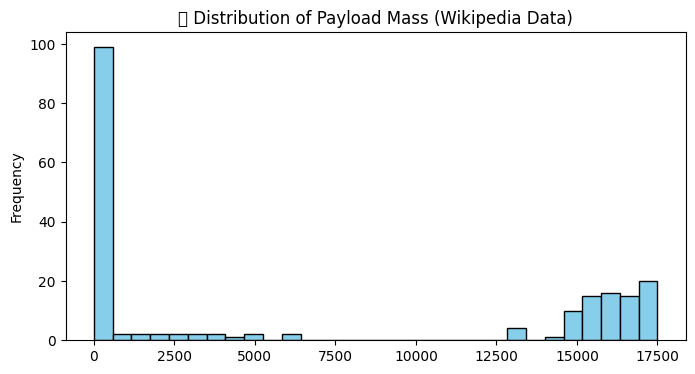

In [7]:
# @title Data Collection: Now Performing Web Scraping Falcon 9 launches from Wikipedia


import pandas as pd
import matplotlib.pyplot as plt
import requests

# Wikipedia page link
wiki_url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
import requests
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(wiki_url, headers=headers)
tables = pd.read_html(response.text, flavor='bs4')  # ✅ works

print(f"✅ {len(tables)} tables found on the page")

# Typically the first few big tables are launch records
df_wiki = tables[2]   # pick the 3rd table (Falcon 9/Heavy launches)
print("Wiki Table Shape:", df_wiki.shape)

# Preview scraped data
display(df_wiki.head(5))

# --- Graphical Overview: Payload mass distribution (where available)
# Clean payload mass column if exists
if "Payload mass" in df_wiki.columns:
    df_wiki["PayloadMass_kg"] = (
        df_wiki["Payload mass"]
        .astype(str)
        .str.extract(r"([\d,]+)")[0]   # extract numbers
        .str.replace(",","", regex=True)
    )
    # Safely convert to numeric (invalid -> NaN)
    df_wiki["PayloadMass_kg"] = pd.to_numeric(df_wiki["PayloadMass_kg"], errors="coerce")

    # Plot histogram
    df_wiki["PayloadMass_kg"].dropna().plot(
        kind="hist", bins=30, figsize=(8,4), color="skyblue", edgecolor="black", title="🚀 Distribution of Payload Mass (Wikipedia Data)"
    )



In [10]:
# @title Data Wrangling

#Data Wrangling (Filter, Clean, Handle Missing, One-Hot Encode)

import pandas as pd
import numpy as np
import plotly.express as px

# --- Use df_launches (from API) and df_wiki (from Wikipedia) ---

# Filtering only Falcon 9 launches
df = df_launches.copy()
df = df[df['name'].str.contains("Falcon 9", na=False)].reset_index(drop=True)

# Extracting relevant columns
df = df[[
    "name", "date_utc", "rocket", "payloads", "cores", "launchpad", "success"
]].copy()

# Convert date & year
df["date"] = pd.to_datetime(df["date_utc"])
df["year"] = df["date"].dt.year

# Join with payloads info (mass, orbit)
payload_info = df_payloads[["id","mass_kg","orbit"]].rename(columns={"id":"payload_id"})
df = df.explode("payloads").merge(
    payload_info, left_on="payloads", right_on="payload_id", how="left"
)

# Cleaning payload mass (useing Wikipedia if missing)
if "PayloadMass_kg" in df_wiki.columns:
    df['mass_kg'] = df['mass_kg'].fillna(
        df_wiki["PayloadMass_kg"].mean()
    )

#Landing success (from cores)

# Extract core IDs from dicts
df["core_id"] = df["cores"].apply(
    lambda x: x[0].get("core") if isinstance(x, list) and len(x) > 0 else None
)

# Merge with df_cores info
core_info = df_cores[["id", "reuse_count", "serial"]]
df = df.merge(core_info, left_on="core_id", right_on="id", how="left")

# Create binary target (success = 1/0)
df["landing_success"] = df["success"].astype(int)

df_model = df[[
    "year", "mass_kg", "orbit", "launchpad", "reuse_count", "landing_success"
]].drop_duplicates()

# Handling missing numeric
df_model["mass_kg"] = df_model["mass_kg"].fillna(df_model["mass_kg"].median())
df_model["reuse_count"] = df_model["reuse_count"].fillna(0)

# One-Hot Encoding of categorical columns
categorical_cols = ["orbit","launchpad"]
df_encoded = pd.get_dummies(df_model, columns=categorical_cols)

print("✅ Data wrangling complete")
print("Final shape:", df_encoded.shape)


# ploting Missing values before/after
missing_before = df_model.isna().sum()
missing_after = df_encoded.isna().sum()

fig1 = px.bar(
    x=missing_before.index, y=missing_before.values,
    labels={"x":"Column","y":"Missing Values"},
    title="🧹 Missing Values Before Cleaning"
)
fig1.show()

fig2 = px.bar(
    x=missing_after.index, y=missing_after.values,
    labels={"x":"Column","y":"Missing Values"},
    title="✅ Missing Values After Cleaning"
)
fig2.show()

# Ploting Landing success distribution
fig3 = px.pie(
    df_model, names="landing_success",
    title="🚀 Landing Success Distribution (0 = Fail, 1 = Success)"
)
fig3.show()

# Ploting Payload mass distribution
fig4 = px.histogram(
    df_model, x="mass_kg", nbins=30,
    title="📦 Distribution of Payload Mass (kg)"
)
fig4.show()



✅ Data wrangling complete
Final shape: (1, 6)


Dataset Shape: (1, 17)
Missing Values:
 name               0
date_utc           0
rocket             0
payloads           0
cores              0
launchpad          0
success            0
date               0
year               0
payload_id         0
mass_kg            0
orbit              0
core_id            0
id                 0
reuse_count        0
serial             0
landing_success    0
dtype: int64


/tmp/ipython-input-2617530608.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




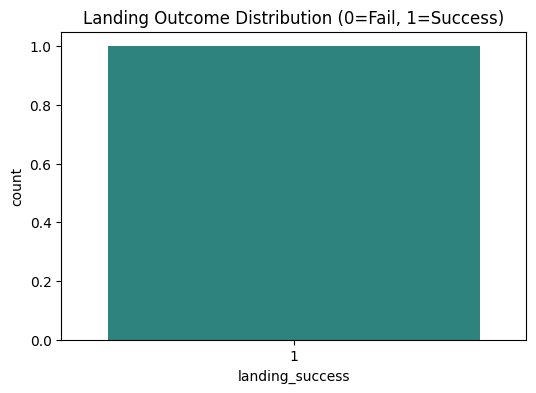

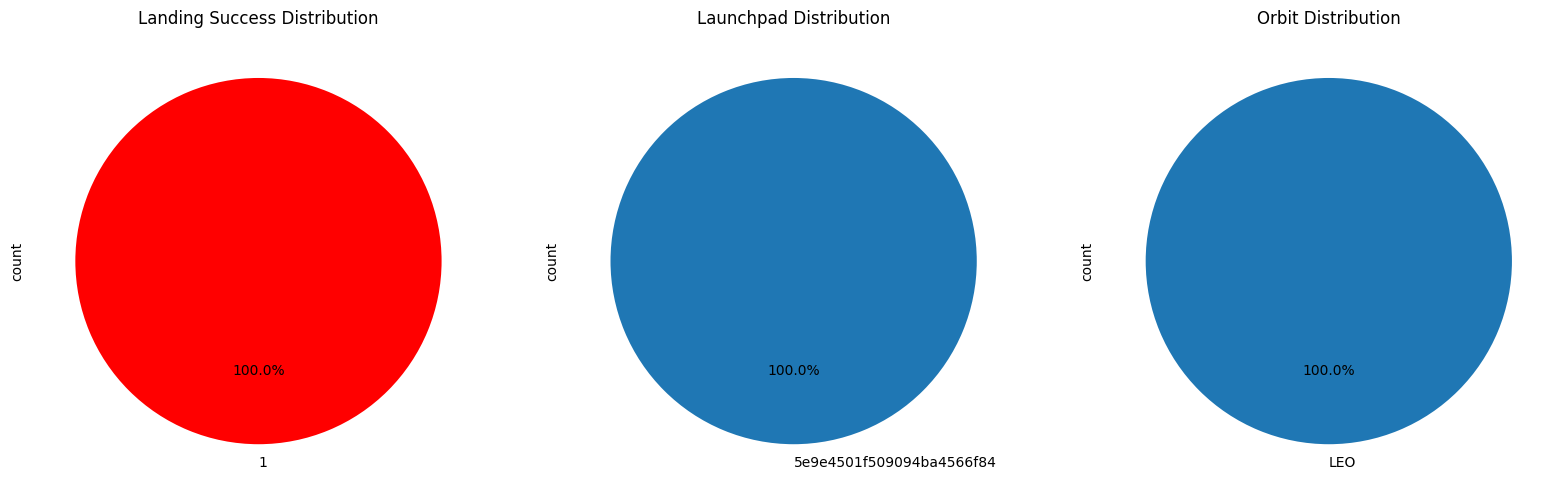

/tmp/ipython-input-2617530608.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




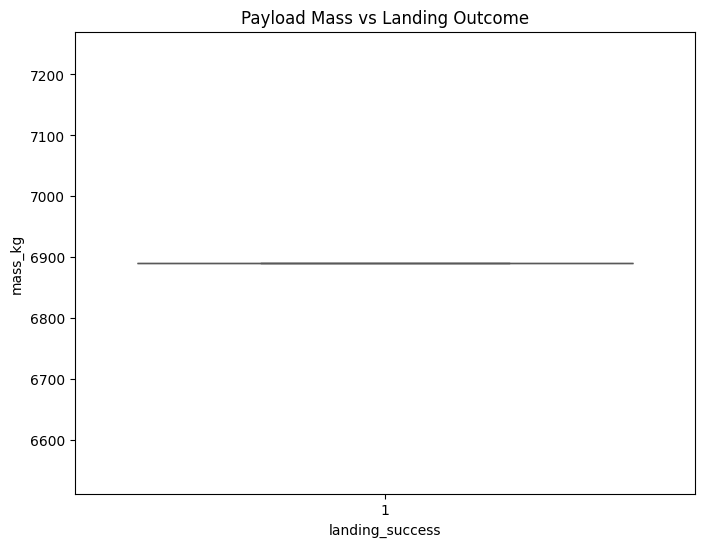

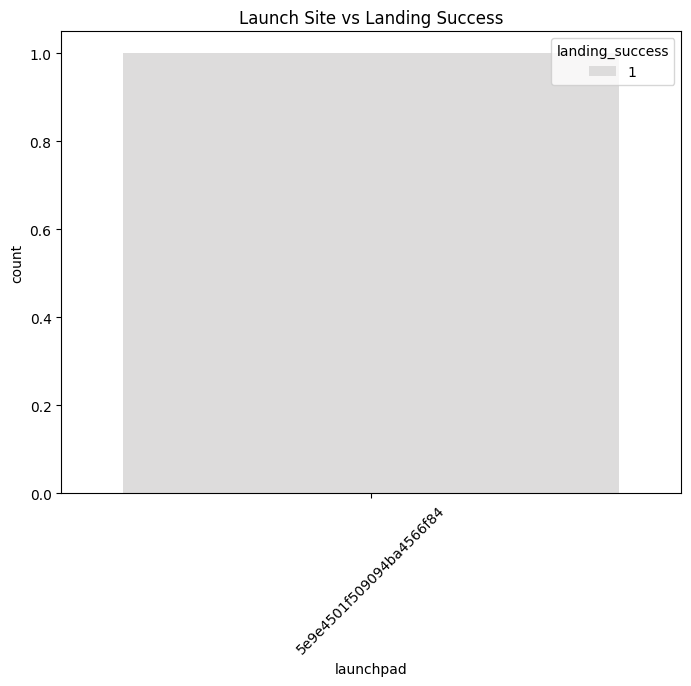

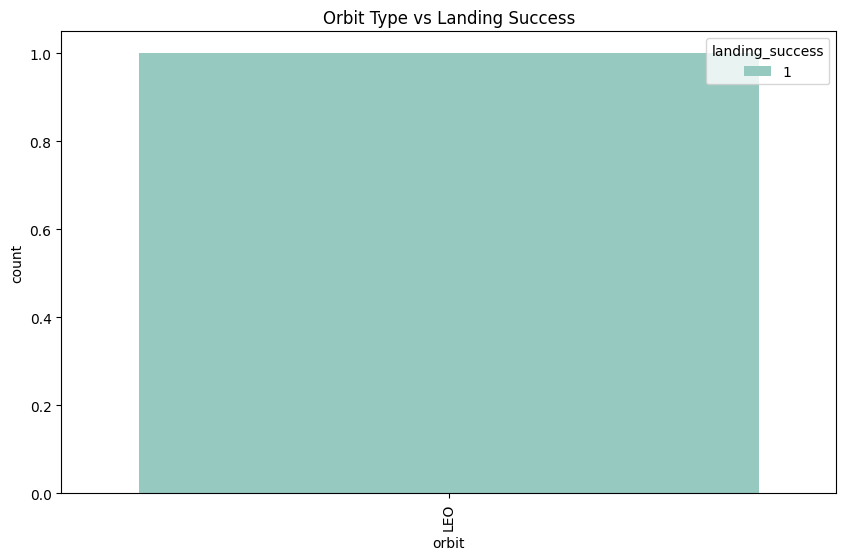

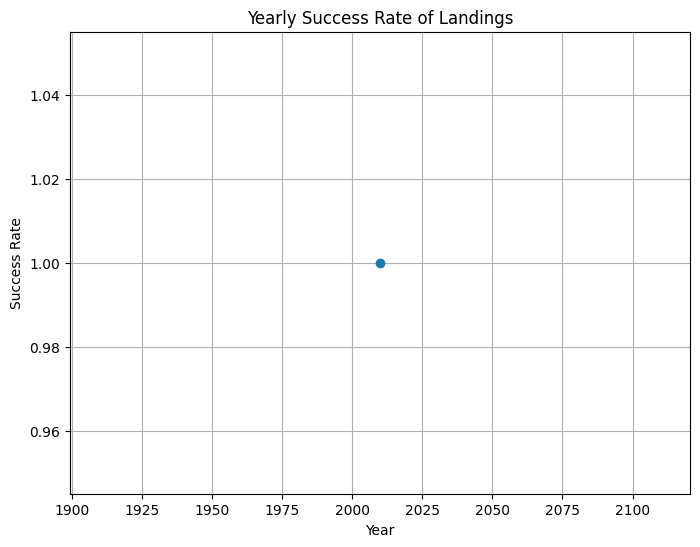


🚀 Success Rate by Launch Site:
                   launchpad  SuccessRate
0  5e9e4501f509094ba4566f84          1.0

🌍 Success Rate by Orbit:
   orbit  SuccessRate
0   LEO          1.0

📅 Success Rate by Year:
    year  SuccessRate
0  2010          1.0


In [13]:
# @title EDA: Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import sqlite3

# Check basic info
print("Dataset Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())

#  Distribution of Target (Landing Success/Failure)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="landing_success", palette="viridis")
plt.title("Landing Outcome Distribution (0=Fail, 1=Success)")
plt.show()

# Pie Charts (Side by Side)
fig, axes = plt.subplots(1, 3, figsize=(16,5))

# Pie 1: Landing Success
df["landing_success"].value_counts().plot.pie(
    ax=axes[0], autopct="%1.1f%%", colors=["red","green"], startangle=90
)
axes[0].set_title("Landing Success Distribution")

# Pie 2: Launch Site
df["launchpad"].value_counts().plot.pie(
    ax=axes[1], autopct="%1.1f%%", startangle=90
)
axes[1].set_title("Launchpad Distribution")

# Pie 3: Orbit
df["orbit"].value_counts().plot.pie(
    ax=axes[2], autopct="%1.1f%%", startangle=90
)
axes[2].set_title("Orbit Distribution")

plt.tight_layout()
plt.show()

# Payload Mass vs Landing Success
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="landing_success", y="mass_kg", palette="Set2")
plt.title("Payload Mass vs Landing Outcome")
plt.show()

# Launch Site vs Success
plt.figure(figsize=(8,6))
sns.countplot(data=df, x="launchpad", hue="landing_success", palette="coolwarm")
plt.title("Launch Site vs Landing Success")
plt.xticks(rotation=45)
plt.show()

# Orbit vs Success
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="orbit", hue="landing_success", palette="Set3")
plt.title("Orbit Type vs Landing Success")
plt.xticks(rotation=90)
plt.show()

# Yearly Trend of Success Rate
success_rate = df.groupby("year")["landing_success"].mean()

plt.figure(figsize=(8,6))
plt.plot(success_rate.index, success_rate.values, marker="o")
plt.title("Yearly Success Rate of Landings")
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.grid(True)
plt.show()

# SQL Queries for Insights
# Convert lists/dicts into strings (SQLite fix)
df_sql = df.copy()
for col in df_sql.columns:
    df_sql[col] = df_sql[col].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)

conn = sqlite3.connect(":memory:")
df_sql.to_sql("spacex", conn, if_exists="replace", index=False)

# Example SQL Queries
q1 = pd.read_sql("SELECT launchpad, AVG(landing_success) as SuccessRate FROM spacex GROUP BY launchpad", conn)
q2 = pd.read_sql("SELECT orbit, AVG(landing_success) as SuccessRate FROM spacex GROUP BY orbit", conn)
q3 = pd.read_sql("SELECT year, AVG(landing_success) as SuccessRate FROM spacex GROUP BY year", conn)

print("\n🚀 Success Rate by Launch Site:\n", q1)
print("\n🌍 Success Rate by Orbit:\n", q2)
print("\n📅 Success Rate by Year:\n", q3)

# Interactive Visualization with Plotly
fig = px.scatter(df, x="mass_kg", y="landing_success",
                 color="orbit", size="mass_kg",
                 hover_data=["launchpad","year"])
fig.update_layout(title="Interactive: Payload Mass vs Landing Success by Orbit")
fig.show()


In [16]:
# @title Creating Dashboard of Launches

import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output


# Ensure lat/long columns exist
if "latitude" in df.columns and "longitude" in df.columns:
    launch_map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()],
                            zoom_start=3, tiles="CartoDB positron")

    marker_cluster = MarkerCluster().add_to(launch_map)

    for _, row in df.iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"Launch Site: {row['launchpad']}<br>Orbit: {row['orbit']}<br>Landing: {row['landing_success']}",
            icon=folium.Icon(color="green" if row["landing_success"] == 1 else "red")
        ).add_to(marker_cluster)

    launch_map.save("launch_sites_map.html")
    print("✅ Folium map saved as launch_sites_map.html")
else:
    # Add coordinates manually
    site_coords = {
        "CCAFS SLC-40": [28.5618571, -80.577366],
        "KSC LC-39A": [28.608389, -80.604333],
        "VAFB SLC-4E": [34.632093, -120.610829],
        "STLS": [25.997264, -97.156084]  # Boca Chica / Starbase
    }

    df["latitude"] = df["launchpad"].map(lambda x: site_coords.get(x, [None, None])[0])
    df["longitude"] = df["launchpad"].map(lambda x: site_coords.get(x, [None, None])[1])

    # Now regenerate the map
    folium_map = folium.Map(location=[28.5618571, -80.577366], zoom_start=3)
    for _, row in df.iterrows():
        if pd.notnull(row["latitude"]) and pd.notnull(row["longitude"]):
            folium.Marker([row["latitude"], row["longitude"]],
                          popup=row["launchpad"]).add_to(folium_map)
    folium_map.save("spacex_launch_map.html")


# DASH APP: Interactive Dashboard

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("🚀 SpaceX Launch Analytics Dashboard", style={"textAlign":"center"}),

    # Dropdown for selecting Orbit
    html.Label("Select Orbit:"),
    dcc.Dropdown(
        id="orbit_dropdown",
        options=[{"label": o, "value": o} for o in df["orbit"].unique()],
        value=df["orbit"].unique()[0],
        clearable=False
    ),

    # Graph 1: Payload vs Landing Success
    dcc.Graph(id="payload_vs_success"),

    # Graph 2: Success Rate by Launch Site
    dcc.Graph(id="site_success"),
])

@app.callback(
    [Output("payload_vs_success", "figure"),
     Output("site_success", "figure")],
    [Input("orbit_dropdown", "value")]
)
def update_dashboard(selected_orbit):
    # Filter by orbit
    dff = df[df["orbit"] == selected_orbit]

    # Plot 1: Payload vs Success
    fig1 = px.scatter(dff, x="mass_kg", y="landing_success",
                      color="launchpad", size="mass_kg",
                      hover_data=["year"],
                      title=f"Payload vs Landing Success ({selected_orbit})")

    # Plot 2: Success Rate by Launchpad
    site_success = dff.groupby("launchpad")["landing_success"].mean().reset_index()
    fig2 = px.bar(site_success, x="launchpad", y="landing_success",
                  color="landing_success", title="Success Rate by Launch Site")

    return fig1, fig2

# Run dashboard (only when executing the script)
if __name__ == "__main__":
    app.run(debug=True, port=8050)



<IPython.core.display.Javascript object>